# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

In [2]:
def euclidian_dist(centroid, x):
    return np.einsum('ij,ij->i', x-centroid, x-centroid)**0.5

print (euclidian_dist(np.matrix((0,0)), np.matrix((1,1))))

[1.41421356]


Load feature names.

In [3]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [5]:
def P1():
### STUDENT START ###

    X_std = stand_array(train_data)
        
    pca = PCA(n_components=50, random_state=1066)
    pca.fit(X_std)

    cumulative_var = 0

# Loop over 50 features
    for feature_ind, feature_name in enumerate(feature_names[0:50]):
    
        feature_ex_var = pca.explained_variance_ratio_[feature_ind]
        cumulative_var+= feature_ex_var
    
        print "Feature: {}  Explained Variance: {:.2f}%  Cumulative: {:.2f}%".format(feature_name, 
                                                                                   feature_ex_var*100, 
                                                                                   cumulative_var*100)
def stand_array(X_arr):
    
    X_std = np.zeros(X_arr.shape)

    for feature_ind in range(len(feature_names)):
        
        feature_mean = np.mean(X_arr[:,feature_ind])
        feature_sd = np.std(X_arr[:,feature_ind])
        
        # Replace x values with standardize values
        X_std[:,feature_ind] = (X_arr[:,feature_ind]-feature_mean)/feature_sd
        
        # Replace NAs with feature_mean
        X_std[np.isnan(X_std)] = feature_mean
        
    return X_std
        
### STUDENT END ###

P1()

Feature: cap-shape=bell  Explained Variance: 8.86%  Cumulative: 8.86%
Feature: cap-shape=conical  Explained Variance: 7.91%  Cumulative: 16.78%
Feature: cap-shape=convex  Explained Variance: 7.13%  Cumulative: 23.91%
Feature: cap-shape=flat  Explained Variance: 5.96%  Cumulative: 29.86%
Feature: cap-shape=knobbed  Explained Variance: 5.26%  Cumulative: 35.13%
Feature: cap-shape=sunken  Explained Variance: 4.52%  Cumulative: 39.65%
Feature: cap-surface=fibrous  Explained Variance: 4.15%  Cumulative: 43.79%
Feature: cap-surface=grooves  Explained Variance: 2.68%  Cumulative: 46.47%
Feature: cap-surface=scaly  Explained Variance: 2.38%  Cumulative: 48.85%
Feature: cap-surface=smooth  Explained Variance: 2.28%  Cumulative: 51.13%
Feature: cap-color=brown  Explained Variance: 1.94%  Cumulative: 53.07%
Feature: cap-color=buff  Explained Variance: 1.85%  Cumulative: 54.92%
Feature: cap-color=cinnamon  Explained Variance: 1.81%  Cumulative: 56.73%
Feature: cap-color=gray  Explained Variance: 1

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


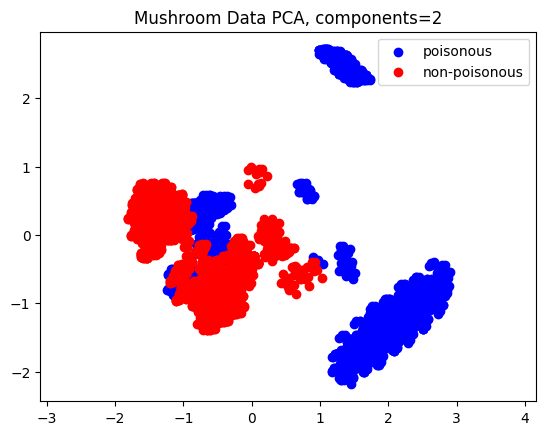

In [6]:
def P2():
### STUDENT START ###

    X_projected = gen_PCA_projection(train_data, 2)
    plot_mushroom_data(X_projected)
    plt.title("Mushroom Data PCA, components={}".format(2))
    plt.show()
    
def gen_PCA_projection(X, comps):
    
    X_std = stand_array(X)
    pca = PCA(n_components=comps, random_state=1066)
    X_projected = pca.fit_transform(X)
    
    return X_projected

def plot_mushroom_data(X_projected):
    
    plt.rcdefaults()
    
    poison_inds = np.where(train_labels==1)
    non_poison_inds = np.where(train_labels==0)
    
    plt.scatter(X_projected[poison_inds,0], X_projected[poison_inds,1], color='b', label='poisonous')
    plt.scatter(X_projected[non_poison_inds,0], X_projected[non_poison_inds,1], color='r', label='non-poisonous')
    plt.legend()
    plt.axis('equal')
    
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


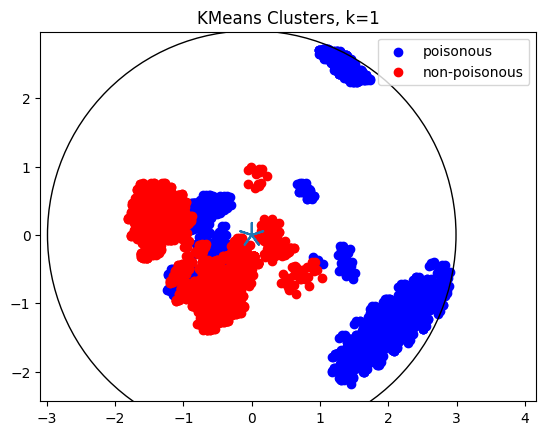

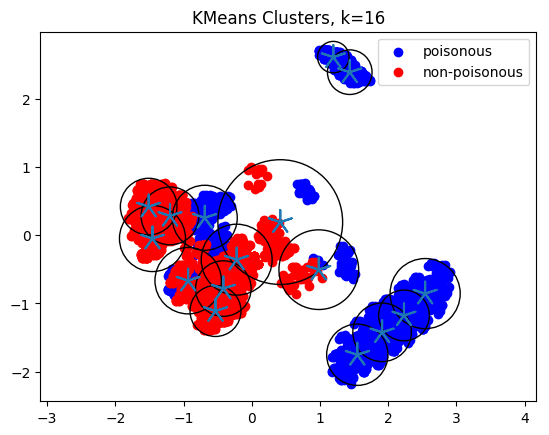

In [7]:
def P3():
### STUDENT START ###

    X_projected = gen_PCA_projection(train_data, 2)

    plot_mushroom_data(X_projected)
    overlay_cluster(X_projected, 1)

    plot_mushroom_data(X_projected)
    overlay_cluster(X_projected, 16)

def euclidian_dist(centroid, x):
    centroid = np.matrix(centroid)
    x = np.matrix(x)
    return np.einsum('ij,ij->i', x-centroid, x-centroid)**0.5
    
def overlay_cluster(X_projected, k=1):
    
    kmeans_cl = KMeans(n_clusters=k, random_state=1066).fit(X_projected)
    
    # Identify centroids for each cluster
    centroids = kmeans_cl.cluster_centers_
        
    # For each sample, identify assigned cluster and compute distance from associated centroid
    cluster_labels = kmeans_cl.fit_predict(X_projected)
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:,1], marker = (5,2), s = (300,300), linewidths = 10, zorder = 10)
        
    max_cluster_dists = []
    
    # Iterate over per-cluster sets of point distances from centroids, saving the max distance in the above list
    #[cluster_ind, max((euclidian_dist(centroid, x)))
    for cluster_ind, centroid in enumerate(centroids):
        max_dist = 0
        
        for x in X_projected[cluster_labels==cluster_ind]:
            distance = euclidian_dist(centroid, x)
            if distance > max_dist:
                max_dist = distance
                
        max_cluster_dists.append(max_dist)
        
    for centroid_ind, dist in enumerate(max_cluster_dists):
        centroid = centroids[centroid_ind]
        circle = plt.Circle((centroid[0], centroid[1]), dist, fill=False)
        ax = plt.gca()
        ax.add_patch(circle)
        
    plt.title("KMeans Clusters, k={}".format(k))
    plt.show()

### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


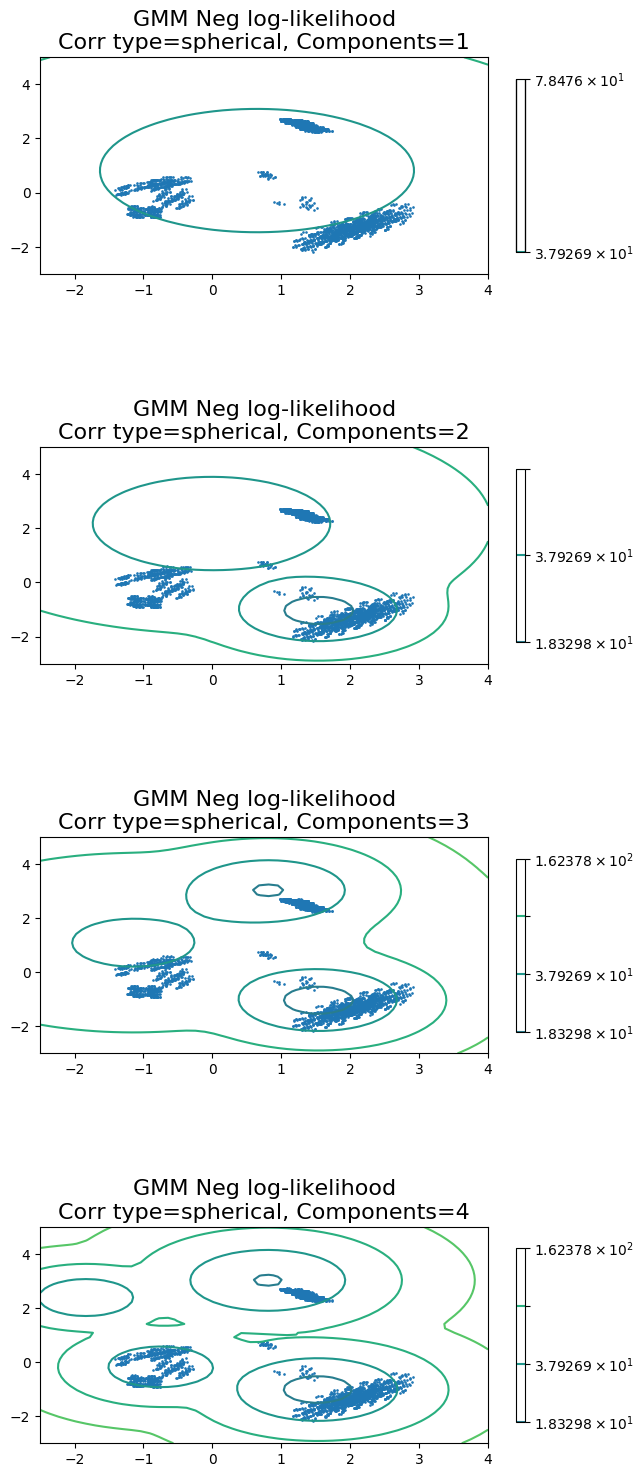

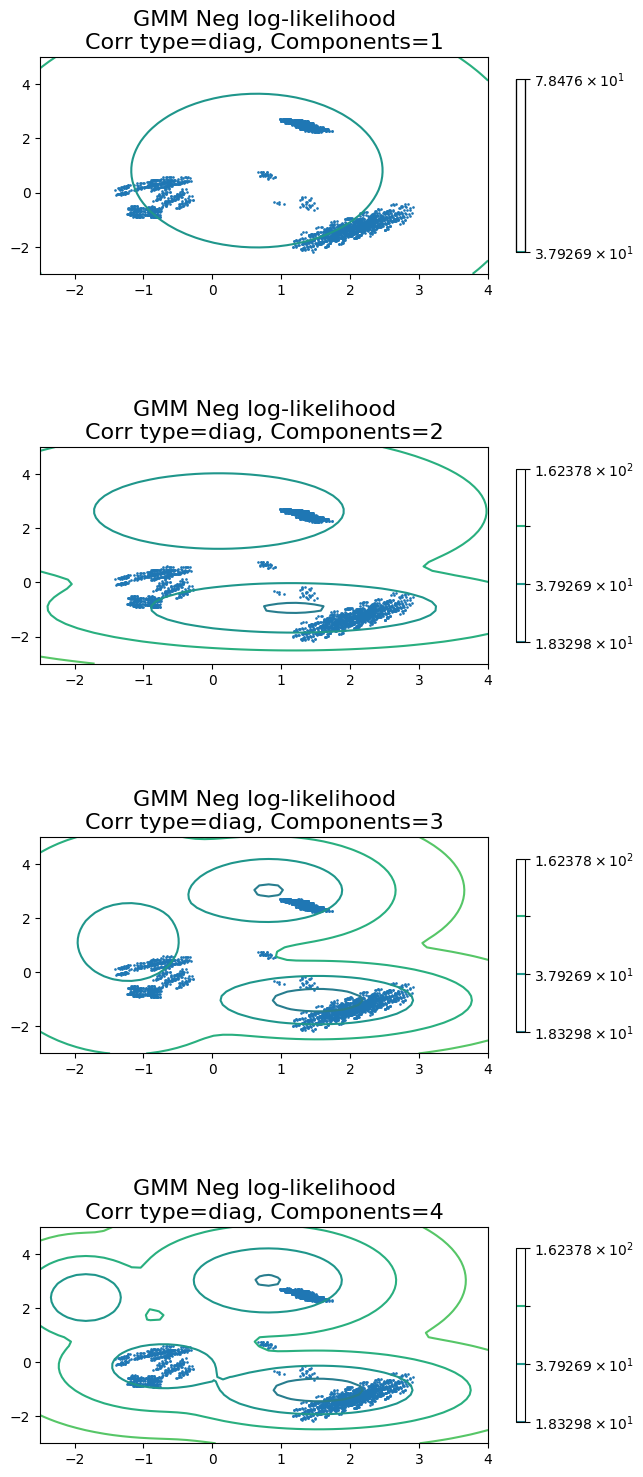

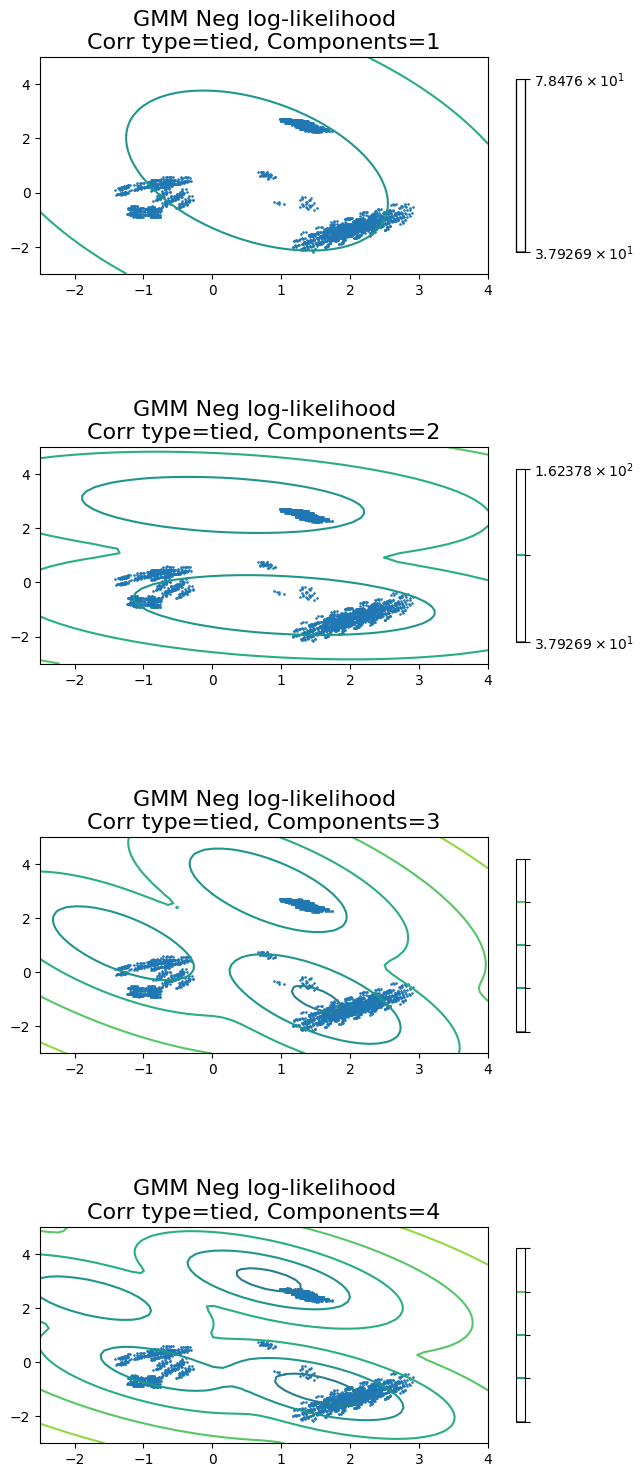

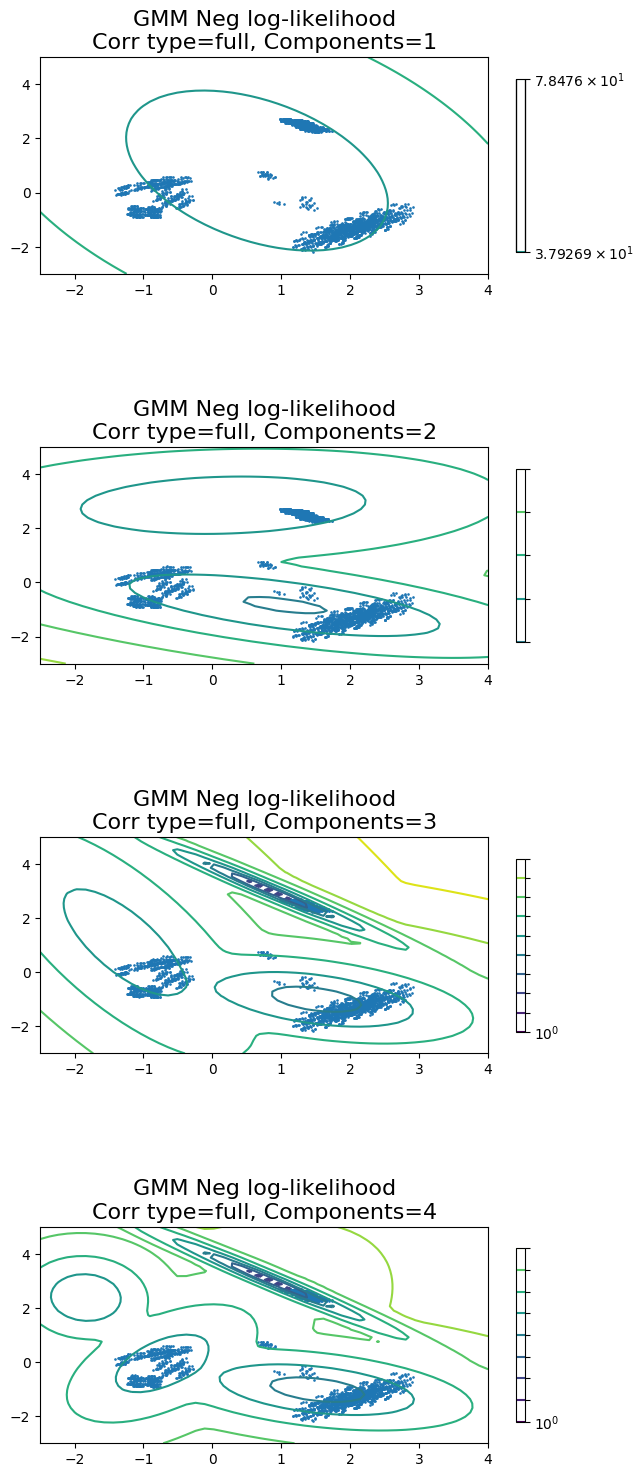

In [8]:
def P4():
### STUDENT START ###

    # The following extra import and function call are for the purpose of ignoring deprecation warnings for GMM
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 

    # Iterate over matrix types, plotting with components from 1-4 for each
    for matrix_type in ['spherical', 'diag', 'tied', 'full']:
        
        # Set a figure size for wider plots
        plt.rcParams['figure.figsize'] = [8, 18]
        fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=4, ncols=1)
        
        
        for components in range(1,5):
            plot_GMM([ax1,ax2,ax3,ax4], components, matrix_type)

        plt.subplots_adjust(left=0.2, wspace=0.8, hspace=0.8)
        plt.show()



def plot_GMM(axes_list, components=4, matrix_type='full'):
    
    gmm = GMM(n_components=components,covariance_type=matrix_type, random_state=1066)

    X_projected = gen_PCA_projection(train_data, 2)
    positive_points = X_projected[np.where(train_labels==1),:][0]

    # generate 1,1 centered stretched Gaussian data
    #C = np.array([[0., -0.7], [3.5, .7]])
    C = np.array([[1., -0.7], [0, 1]])
    stretched_positive_points = np.dot(positive_points, C)+np.array([-1, 2])
    
    
    # concatenate the two datasets into the final training set
    X_train = np.vstack([positive_points, stretched_positive_points])
    
    gmm.fit(X_train)

    
    # display predicted scores by the model as a contour plot
    x = np.linspace(-2.5, 4.)
    y = np.linspace(-3., 5.)
    X_comp, Y_comp = np.meshgrid(x, y)
    XX = np.array([X_comp.ravel(), Y_comp.ravel()]).T
    sample_scores = gmm.score_samples(XX)

    Z_comp = -(gmm.score_samples(XX)[0])*10
    Z_comp = Z_comp.reshape(X_comp.shape)

    # Select the axes for the number of components (components 1-4 = list index 0-3)
    ax = axes_list[components-1]
    
    CS = ax.contour(X_comp, Y_comp, Z_comp, norm=LogNorm(vmin=1, vmax=1000.0),
                 levels=np.logspace(0, 6, 20))
    
    CB = plt.colorbar(CS, shrink=0.8, extend='both', ax=ax)
    
    ax.scatter(positive_points[:, 0], positive_points[:, 1], .8)
    ax.set_title('GMM Neg log-likelihood\nCorr type={}, Components={}'.format(matrix_type, components), fontsize=16)

### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [9]:
def P5():
### STUDENT START ###
    X_projected = gen_PCA_projection(train_data, 2)
    X_test_projected = gen_PCA_projection(test_data, 2)
    
    positive_points = X_projected[np.where(train_labels==1),:][0]
    pos_labels = np.ones_like(test_labels)

    gmm_pos = GMM(n_components=4,covariance_type='full')
    gmm_pos.fit(positive_points)
    pos_score = gmm_pos.score(X_test_projected)
    
    negative_points = X_projected[np.where(train_labels==0),:][0]
    neg_labels = np.zeros_like(test_labels)

    gmm_neg = GMM(n_components=4,covariance_type='full')
    gmm_neg.fit(negative_points)
    neg_score = gmm_neg.score(X_test_projected)

    # Combine the preductions, producing a label of 1 (non-poisonous) where the negative GMM score is higher
    # and a label of 0 (non-poisonous) GMM score is higher. Note that in the case of a tie between the GMM scores,
    # the mushroom will be labeled poisonous, which is a good default if you're picking mushrooms in the forest to eat.
    combined_prediction = np.where((neg_score>pos_score),neg_labels,pos_labels)
    print("combined_prediction: ")
    print(combined_prediction)
    
    combined_accuracy = metrics.accuracy_score(test_labels, combined_prediction)
    print("Combined accuracy: {:3.2f}%".format(100*combined_accuracy))
    
    







### STUDENT END ###

P5()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


combined_prediction: 
[1 1 1 ... 0 0 1]
Combined accuracy: 51.25%


### Answer
The combined prediction of two GMMs (one fitted with negative examples and one with positive examples) has an accuracy of just 51%, which basically only as good as a coin toss.

This makes sense, since a GMM requires both examples and counter examples for effective prediction, and in this case each GMM was given only all positive/negative examples.

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [19]:
def P6():
### STUDENT START ###

    test_score_fields = [('matrix_type', 'U10'), ('pca_comps', 'i4'), ('gmm_comps', 'i4'), ('score', 'f8')]
    test_scores = []
    
    print("Computing accuracy scores across matrix types, number of PCA components, and number of GMM components...")
    # Iterate over matrix types, PCA components, and GMM components, computing score for each

    for matrix_type in ['spherical', 'diag', 'tied', 'full']:
        
        for pca_comps in range(2,6):
            
            for gmm_comps in range(2,6):
                
                if 2*pca_comps*gmm_comps*2<=50:
                    
                    test_scores.append((matrix_type, pca_comps, gmm_comps, 
                                        compute_score(matrix_type, pca_comps, gmm_comps)))
    
    test_scores = np.array(test_scores, dtype = test_score_fields)
    
    np.sort(test_scores)
    
    best = test_scores[np.where(test_scores['score']==max(test_scores['score']))]
    
    print("\nThe best scores were produced by the following PCA/GMM configuration:")
    for score in best:
        matrix_type = score['matrix_type']
        pca_comps = score['pca_comps']
        gmm_comps = score['gmm_comps']
        score_val = score['score']
        print("Matrix type: {}  PCA comps: {}  GMM comps: {}  Accuracy Score: {:.4f}".format(matrix_type,
                                                                                             pca_comps,
                                                                                             gmm_comps,
                                                                                             score_val))
        print("There were {} total parameters for this configuration.".format(2*pca_comps*gmm_comps*2))
    
                    
def compute_score(matrix_type='full', pca_comps=2, gmm_comps=2):
    
    X_projected = gen_PCA_projection(train_data, pca_comps)
    gmm = GMM(n_components=gmm_comps,covariance_type=matrix_type, random_state=1066)
    gmm.fit(X_projected)
    
    test_projected = gen_PCA_projection(test_data, pca_comps)
    
    score = metrics.accuracy_score(test_labels, gmm.predict(test_projected))

    print("For matrix_type {}, PCA components={}, and GMM components={}, accuracy was {}.".format(matrix_type,
                                                                                                 pca_comps,
                                                                                                 gmm_comps,
                                                                                                 score))
    
    return score 
        
### STUDENT END ###

P6()

Computing accuracy scores across matrix types, number of PCA components, and number of GMM components...
For matrix_type spherical, PCA components=2, and GMM components=2, accuracy was 0.19128113879.


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


For matrix_type spherical, PCA components=2, and GMM components=3, accuracy was 0.361209964413.
For matrix_type spherical, PCA components=2, and GMM components=4, accuracy was 0.317615658363.
For matrix_type spherical, PCA components=2, and GMM components=5, accuracy was 0.00444839857651.
For matrix_type spherical, PCA components=3, and GMM components=2, accuracy was 0.255338078292.
For matrix_type spherical, PCA components=3, and GMM components=3, accuracy was 0.361209964413.
For matrix_type spherical, PCA components=3, and GMM components=4, accuracy was 0.361209964413.
For matrix_type spherical, PCA components=4, and GMM components=2, accuracy was 0.681494661922.
For matrix_type spherical, PCA components=4, and GMM components=3, accuracy was 0.361209964413.
For matrix_type spherical, PCA components=5, and GMM components=2, accuracy was 0.318505338078.
For matrix_type diag, PCA components=2, and GMM components=2, accuracy was 0.321174377224.
For matrix_type diag, PCA components=2, and